In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from skimage.measure import shannon_entropy
import os
import cv2
from sklearn.metrics import mean_squared_error, r2_score

def normalized_variance(image):
	mean = np.mean(image)
	var = np.var(image)
	return np.divide(var, mean)

def normalize_zstack(zstack, each_plane = True, dest_dtype = np.uint16,):

    if dest_dtype == np.uint16:
        dest_dtype_cv2 = cv2.CV_16U
        max_value = np.iinfo(dest_dtype).max
    elif dest_dtype == np.uint8:
        dest_dtype_cv2 = cv2.CV_8U
        max_value = np.iinfo(dest_dtype).max
    elif dest_dtype == np.float32:
        dest_dtype_cv2 = cv2.CV_32F
        max_value = 1
    elif dest_dtype == np.float64:
        dest_dtype_cv2 = cv2.CV_64F
        max_value = 1
    else:
        raise ValueError("dest_dtype must be one of np.uint16, np.uint8, np.float32, np.float64")

    output_zstack = np.zeros_like(zstack, dtype=dest_dtype)
    if each_plane:
        output_zstack = np.array([cv2.normalize(plane, None, 0, max_value, # type: ignore
						  cv2.NORM_MINMAX, dtype=dest_dtype_cv2) for plane in zstack])
    else:
        output_zstack = cv2.normalize(zstack, None, 0, max_value, # type: ignore
                          cv2.NORM_MINMAX, dtype=dest_dtype_cv2)
    return output_zstack

manual_pumping_count_csv = "../pumping_manual_old_experiment.csv"
manual_pumping_count_dataframe = pd.read_csv(manual_pumping_count_csv).dropna()

auto_pumping_count_csv = "../pumping_auto_old_experiment.csv"
auto_pumping_count_dataframe = pd.read_csv(auto_pumping_count_csv).dropna(subset=['PumpingVideos'])

30
0.885881155021037
14.85


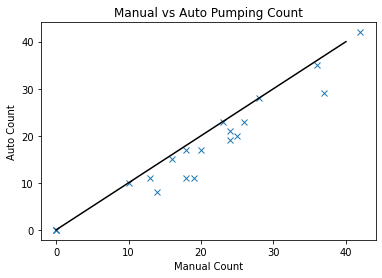

In [24]:
valid_videos = manual_pumping_count_dataframe[manual_pumping_count_dataframe['ManualPumpCount'] >= 0]
excluded_videos = manual_pumping_count_dataframe[manual_pumping_count_dataframe['ManualPumpCount'] == -1]

valid_video_path = valid_videos['ImagePath'].tolist()
# replace /mnt by //izbkingston in the path
# valid_video_path = [path.replace('/mnt', '//izbkingston') for path in valid_video_path]
print(len(valid_video_path))
p = []

for path in valid_video_path:
    # path = path.replace('//izbkingston', '/mnt')
    manual_count = valid_videos[valid_videos['ImagePath'] == path]['ManualPumpCount'].tolist()[0]
    # path = path.replace('/mnt', '//izbkingston')
    auto_count = auto_pumping_count_dataframe[auto_pumping_count_dataframe['PumpingVideos'] == path]['PumpCount'].tolist()[0]
    if np.isfinite(auto_count):
        p.append([manual_count, auto_count, path])



p = sorted(p, key=lambda x: (x[0], x[1]))
# p = np.array(p)

p_for_plot = [[p[0], p[1]] for p in p]
r2_score = r2_score([p[0] for p in p_for_plot], [p[1] for p in p_for_plot])
mean_squared_error = mean_squared_error([p[0] for p in p_for_plot], [p[1] for p in p_for_plot])
print(r2_score)
print(mean_squared_error)

plt.plot(*zip(*p_for_plot), 'x')
plt.plot([0, 40], [0, 40], 'k-')
plt.xlabel('Manual Count')
plt.ylabel('Auto Count')
plt.title('Manual vs Auto Pumping Count')
plt.show()

In [ ]:
from scipy.signal import find_peaks
import skimage.exposure
from skimage.filters.rank import entropy
from skimage.measure import shannon_entropy
from scipy.signal import medfilt
import xgboost as xgb

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def normalized_variance(image):
	mean = np.mean(image)
	var = np.var(image)
	return np.divide(var, mean)

def normalize_image(image, dest_dtype=np.uint16):
    dtype_mapping = {
        np.uint16: cv2.CV_16U,
        np.uint8: cv2.CV_8U,
        np.float32: cv2.CV_32F,
        np.float64: cv2.CV_64F
    }

    if dest_dtype not in dtype_mapping:
        raise ValueError("dest_dtype must be one of np.uint16, np.uint8, np.float32, np.float64")

    dest_dtype_cv2 = dtype_mapping[dest_dtype]
    max_value = np.iinfo(dest_dtype).max if dest_dtype in [np.uint16, np.uint8] else 1

    return cv2.normalize(image, None, 0, max_value, cv2.NORM_MINMAX, dtype=dest_dtype_cv2) # type: ignore

def extract_features(img, features_size):
    img = normalize_image(img)
    std = np.std(img, axis =0)
    feature = np.zeros((1,features_size))
    feature[0, 0:std.shape[0]] = std
    return feature

def extractPump_norm(straightened_image, clf):
    feature = extract_features(straightened_image, 5000)
    orientation_prediction = clf.predict_proba(feature).squeeze()
    # convert proba to one hot encoding
    pred_class = np.argmax(orientation_prediction)
    orientation = [0, 0, 0]
    orientation[pred_class] = 1
    
    std = np.std(straightened_image, axis =0)

    peaks, peak_dict = find_peaks(std, distance=20, prominence = 0.05, height = 0.1)

    if orientation == [1, 0, 0]:
        # print(std[peaks[-1]])
        # plt.plot(std)
        # plt.plot(peaks[-1], std[peaks[-1]], "x")
        # plt.show()
        try:
            # return -peak_dict['peak_heights'][-1], orientation
            return -np.mean(straightened_image, axis =0)[peaks[-1]]/peak_dict['peak_heights'][-1], orientation
        except IndexError:
            return np.nan, orientation
    elif orientation == [0, 1, 0]:
        # print(std[peaks[0]])
        # plt.plot(std)
        # plt.plot(peaks[0], std[peaks[0]], "x")
        # plt.show()
        try:
            # return -peak_dict['peak_heights'][0], orientation
            return -np.mean(straightened_image, axis =0)[peaks[0]]/peak_dict['peak_heights'][0], orientation
        except IndexError:
            return np.nan, orientation
    else:
        return np.nan, orientation
    

def count_orientation_errors(orientation):
    # errors = np.count_nonzero(np.array(orientation) == [0, 0, 1])
    errors = 0
    for orient in orientation:
        if orient == [0, 0, 1]:
            errors += 1
    return errors

def count_orientation_flip(orientation):
    flips = 0
    for i in range(len(orientation)-1):
        if orientation[i] != orientation[i+1]:
            flips += 1
    return flips
def analyse_video(vid, model):

    pump = []
    orientation = []

    clf = xgb.XGBClassifier()
    clf.load_model(model)
    
    for i in range(vid.shape[0]):
        pump_value, orient = extractPump_norm(vid[i, :, :], clf)
        pump.append(pump_value)
        orientation.append(orient)

    orientation_errors = count_orientation_errors(orientation)
    print(f'orientation errors % : {orientation_errors/len(orientation)}')
    print(f'orientation flips : {count_orientation_flip(orientation)}')
    if orientation_errors/len(orientation) > 0.15:
        return np.nan
    
    pump = np.array(pump)

    pump = medfilt(pump)

    nans, x= nan_helper(pump)
    pump[nans]= np.interp(x(nans), x(~nans), pump[~nans])

    pump = medfilt(pump)
    
    std = np.std(pump)
    std = max(std, 0.008)
    peaks, _ = find_peaks(pump, distance=4, prominence=1.25*std, wlen=10)

    plt.plot(pump)
    plt.plot(peaks, pump[peaks], "x")
    plt.show()

    return len(peaks)


def process_video(video_path):
    if video_path:
        vid = imread(video_path)
        plt.imshow(vid[25])
        plt.show()
        mean_normalized_variance_of_vid = np.mean([normalized_variance(frame) for frame in vid])
        if mean_normalized_variance_of_vid < 500:
            return np.nan
        normalized_vid = normalize_zstack(vid, each_plane = False, dest_dtype = np.float64) # type: ignore
        # normalized_vid = normalize_zstack(vid, dest_dtype=np.float64, each_plane = True)
        # normalized_vid = vid
        return analyse_video(normalized_vid, model="../../classify_orientation/model.json")
    else:
        return np.nan

[16.0, 11.0, '//izbkingston/external.data/TowbinLab/kstojanovski/20220629_Ti2_20x_160-182-190_pumping_25C_20220629_154238_325/analysis/str_pharynx_videos/Time00115_Point0037_Channel575_nm_Seq5948_pharynx.tiff']


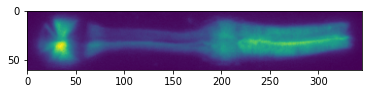

orientation errors % : 0.0
orientation flips : 0


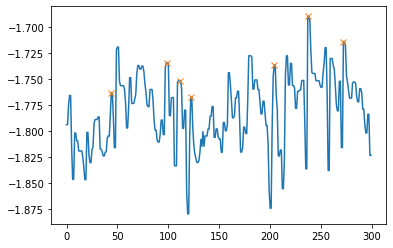

7


In [ ]:
worst_auto_count = max(p, key=lambda x: abs(float(x[0])-float(x[1])))
best_auto_count = min(p, key=lambda x: abs(float(x[0])-float(x[1])))

sorted_by_quality = sorted(p, key=lambda x: abs(float(x[0])-float(x[1])), reverse=True)
idx =5
print(sorted_by_quality[idx])
print(process_video(sorted_by_quality[idx][2]))